In [1]:
import os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import dianna
from dianna.methods import DeepLift
from dianna import visualization

In [2]:
data = np.load('./binary-mnist.npz')
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1])/255
y_test = data['y_test'].astype(int)

In [3]:
class MnistNet(nn.Module):
    """
    Model designed for mnist. This class works with the load_torch_model
    function for testing deeplift in dianna.
    """

    def __init__(self, kernels=[16, 32], dropout=0.1, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(MnistNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1],
                      kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # pixel 28 / maxpooling 2 * 2 = 7
        self.fc1 = nn.Linear(7 * 7 * kernels[-1], kernels[-1])
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


def load_torch_model(path_to_model):
    """
    Load pytorch model
    Args:
        path_to_model (str):
    Returns:
        pytorch model
    """
    # create the structure of the model
    # hyper-parameters
    kernels = [16, 32]
    dropout = 0.5
    classes = 2
    # create model
    model = MnistNet(kernels, dropout, classes)
    # load whole model state
    checkpoint = torch.load(path_to_model)
    # load model
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model

In [4]:
model = load_torch_model(os.path.expanduser('~/surfdrive/Shared/datasets/mnist/mnistnet_training_checkpoint.pt'))

In [5]:
# select a random image from binary MNIST
idx = np.random.choice(len(X_test))
X = X_test[idx:idx+1]
y = y_test[idx]

# move channel axis from end to second position
X = np.transpose(X, (0, 3, 1, 2))

In [9]:
deeplift = DeepLift()
heatmap = deeplift.explain_image(model, X, label=y)

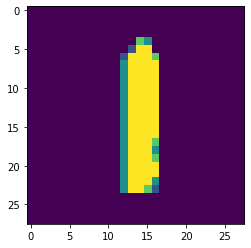

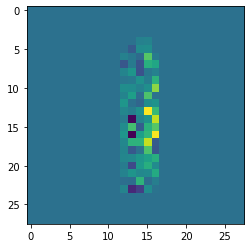

In [17]:
plt.imshow(X[0,0])
visualization.plot_image(heatmap[0,0])